# MINOS reproduction

In [1]:
! pip3 install -r requirements.txt 
# Uncomment the following only if GPU supported
#! pip3 install tensorflow-gpu==2.7.0 

In [2]:
# Imports

import os
import sys
import pandas as pd
import numpy as np
import time

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Reshape, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_keras
from concurrent.futures import ThreadPoolExecutor

import keras

import matplotlib.pyplot as plt
import os

from datetime import datetime

In [3]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
# Using MODIN for fast loading of datasets
# https://modin.readthedocs.io/en/stable/
os.environ["MODIN_CPUS"] = "16"
os.environ["MODIN_ENGINE"] = "ray"
os.environ["RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE"] = "1"
import ray
ray.shutdown()
# Watch out for the tmp folder, to send ray temporary files to another location, set the parameter _temp_dir
ray.init(num_cpus=16)
import modin.pandas as pdfast

OSError: [Errno 30] Read-only file system: '/datadrive'

In [4]:
# The following code is for latex plotting like
from distutils.spawn import find_executable

# Checking is latex is installed in the syste to generate latex like plots
if find_executable('latex'): 
    print("latex installed")
    import matplotlib.pyplot as plt
    import matplotlib
    from math import sqrt
    SPINE_COLOR = 'gray'
    plt.style.use('seaborn-colorblind')
    import re

    tick_y_size = 8
    tick_x_size = 8
    title_size = 12

    def latexify(fig_width=None, fig_height=None, columns=1, font_size=12, tick_size=12):
        """Set up matplotlib's RC params for LaTeX plotting.
        Call this before plotting a figure.

        Parameters
        ----------
        fig_width : float, optional, inches
        fig_height : float,  optional, inches
        columns : {1, 2}
        """

        if fig_width is None:
            fig_width = 3.7 if columns==1 else 6.9 # width in inches

        if fig_height is None:
            golden_mean = (sqrt(5)-1.0)/2.0	# Aesthetic ratio
            fig_height = fig_width*golden_mean + 1.2 # height in inches

        pgf_with_latex = {					  # setup matplotlib to use latex for output
            "pgf.texsystem": "pdflatex",		# change this if using xetex or lautex
            "text.usetex": True,				# use LaTeX to write all text
            "font.family": "serif",
            "font.serif": [],				   # blank entries should cause plots
            "font.monospace": [],
            "axes.labelsize": font_size,			   # LaTeX default is 10pt font.
            "font.size": font_size,
            "legend.fontsize": font_size,			   # Make the legend/label fonts
            "xtick.labelsize": tick_size,			   # a little smaller
            "ytick.labelsize": tick_size,
            "figure.figsize": [fig_width, fig_height],	 # default fig size of 0.9 textwidth
            #"pgf.preamble": [
            #	r"\\usepackage[utf8x]{inputenc}",	# use utf8 fonts
            #	r"\\usepackage[T1]{fontenc}",		# plots will be generated
            #	r"\\usepackage[detect-all,locale=DE]{siunitx}",
            #	]								   # using this preamble
            }

        matplotlib.rcParams.update(pgf_with_latex)


    def format_axes(ax, hide = ['top', 'right'], show= ['left', 'bottom']):

        for spine in hide:
            ax.spines[spine].set_visible(False)

        for spine in show:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_tick_params(direction='out', color=SPINE_COLOR)

        return ax

    latexify(font_size=14, tick_size=11)
else:
    print("latex is not installed")
    
    def latexify(fig_width=None, fig_height=None, columns=1, font_size=8, tick_size=8):
        # Nothing
        pass

    def format_axes(ax, hide = ['top', 'right'], show= ['left', 'bottom']):
        # Nothing
        return ax

    latexify()

latex installed


In [5]:
# Helper methods

# Split the dataset for testing and training
def split(df, testfraction=0.5):
    cp = df.copy()    
    index_to_cut = int(len(cp.index)*(testfraction))
    shuffled = np.random.permutation(cp.index)
    pref, suf = shuffled[:index_to_cut], shuffled[index_to_cut:]
    
    assert len(pref) + len(suf) == len(cp.index)
    return cp.loc[pref], cp.loc[suf]


# Creates the folds for a given dataset
def folds(df, nofolds=10):
    chunk_size = int(len(df.index)/nofolds) + 1 # ceiling approx.
    permutation = np.random.permutation(df.index)
    
    folds = [ df.loc[permutation[chunk_size*i:chunk_size*(i + 1)]].copy() for i in range(nofolds)]
    
    return folds

# Given correct labels, returns the accuracy of the model predictions
def accuracy(df, correctlabels):
    acc = 0
    for prediction, correct in zip(df.iloc, correctlabels):
        if prediction.idxmax() == correct:
            acc += 1
            
    return acc/len(df.index)

# To plot ROC and get the AUC
def plot_roc(fpr_keras, tpr_keras, auc_keras_val, filename, title="ROC curve"):
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"plots/{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr_keras, tpr_keras, label='auc = {:.3f}'.format(auc_keras_val))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(title)
    ax.legend(loc='best')
    plt.tight_layout()
    
    sanitized_name = f"plots/{filename}".replace("_", ".")
    fig.savefig(sanitized_name)
    
# To plot accuracy
def plot_accuracy(epochs, accuracy, validation_acc, filename):    
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"plots/{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    ax.plot(epochs, accuracy, 'bo', label='Training acc')
    ax.plot(epochs, validation_acc, 'r', label='Validation acc')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and\nvalidation accuracy')
    ax.legend()    
    plt.tight_layout()
    fig.savefig(sanitized_name)


# To plot loss
def plot_loss(epochs, loss, validation_loss, filename):
    fig, ax = plt.subplots()    
    format_axes(ax, hide=[], show=['top', 'left', 'right', 'bottom'])
    sanitized_name = f"plots/{filename}".replace("_", ".")
    print(f"Plotting {sanitized_name}")
    
    ax.plot(epochs, loss, 'bo', label='Training loss')
    ax.plot(epochs, validation_loss, 'r', label='Validation loss')
    ax.set_title('Training and\nvalidation loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.tight_layout()
    
    fig.savefig(sanitized_name)
    
def plot_pca(df, name):
    plt.figure() # clean the buffer
    # trying PCA to see the distribution of the samples
    from sklearn.decomposition import PCA

    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    X = df[pixels].values
    Xb = df[df['CLASS'] == 'BENIGN']
    Xb = Xb[pixels].values
    Xm = df[df['CLASS'] == 'MALIGN']
    Xm = Xm[pixels].values

    pca = PCA(n_components=2, whiten=True).fit(X)
    X_pcab = pca.transform(Xb)
    X_pcam = pca.transform(Xm)


    row = 0
    col = 1

    plt.scatter(X_pcab[:,row],X_pcab[:,col],c='b', alpha=0.5)
    plt.scatter(X_pcam[:,row],X_pcam[:,col],c='r', alpha=0.5)

    # blue for benign
    # red for malign

    plt.savefig(name)
    
def plot_manifolds(df, name):
    plt.figure() # clean the buffer
    from sklearn.manifold import MDS
    model = MDS(n_components=2, random_state=2)
    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    X = df[pixels].values
    
    manifolds = model.fit_transform(X)
    colors = df['CLASS'].values
    colors = [[1, 0,0,0.5] if c == 'MALIGN' else [0,0,1, 0.5] for c in colors]

    plt.scatter(manifolds[:, 0], manifolds[:, 1], c=colors)
    plt.axis('equal');
    plt.savefig(name)
    
def img_sample(sample):
    # clean out matplotlib.pyplot
    plt.figure()
    pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

    print(sample['Name'], sample['CLASS'])
    values = sample[pixels].values
    values = values.reshape((100,100))

    plt.imshow(np.float32(values))

# Experiments

In [6]:
# Parameters for plotting and model saving

PLOT_FIT = True
LOAD_IF_COMPILED = True

# MINOS class
class MINOS:

    # Use this field to refer to the index of the correct label,
    # for example, `MINOS.classes.index("MALIGN")` or `MINOS.classes[0]`
    classes = ['MALIGN', 'BENIGN']

    def __init__(self, size=(100,100), add_maxpool=True):

        # Create and compile the CNN following the instructions from MINOS
        model = Sequential()
        model.add(Reshape((*size, 1), input_shape=(size[0]*size[1], )))
        model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(*size,1)))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, kernel_size=3, activation='relu'))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        if add_maxpool:
            model.add(MaxPooling2D(pool_size=(2, 2)))
            
        model.add(Flatten())
        model.add(Dense(2, activation='softmax'))

        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # To print the summary of the CNN model, layers, parameters, etc
        model.summary()

        self.model = model

        
    # This method returns a collection of the image datas.
    # This method group the columns representing the pixel values, each pixel value is
    # stored in a column with the name `<row>_<column>` in the 100x100 binary transformation
    def preprocess(self, data, shape=(100,100)):
        r = data.groupby(by='CLASS').apply(lambda x: len(x))
        display(r)
        
        features = [f"{x}_{y}" for x in range(shape[0]) for y in range(shape[1])]
        # Categorize data
        labels = data['CLASS'].apply(lambda x: MINOS.classes.index(x))
        labels = to_categorical(labels)

        
        # iterate the data and load the nyd
        values = data[features].values
        return values, np.array(labels)

    # Train the classifier
    def fit(self, train_data, test_data, epochs=50, model_name="minos.h5"):
        
        # This check, will avoid to train the model again if the model 
        # was already saved in the filesystem. This will help us to prevent
        # the model creating on every exeution of the fit method.
        if not os.path.exists(model_name):
            # Some counting for info
            X_train, Y_train = self.preprocess(train_data)
            X_test, Y_test = self.preprocess(test_data)

            # for plotting
            checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                                monitor = 'val_acc',
                                verbose=1, 
                                save_best_only=True)
            history = self.model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=[checkpointer], epochs=epochs)
            
            self.model.save(model_name)

            # To plot the accuracy and lost per epoch
            if PLOT_FIT:
                acc = history.history['accuracy']
                val_acc = history.history['val_accuracy']
                loss = history.history['loss']
                val_loss = history.history['val_loss']
                
                epochs = range(1, len(acc) + 1)
                plot_accuracy(epochs, acc, val_acc, f"Accuracy_{model_name}.pdf")
                plot_loss(epochs, loss, val_loss, f"Loss_{model_name}.pdf")
                
                self.acc4plot = [(epochs, acc, val_acc), (epochs, loss, val_loss)]
                
        # Otherwise, just load the model from the file system
        else:
            self.model = keras.models.load_model(model_name)
            


    # Given dataframe, uses the fitted model to 
    # predict the labels
    def predict(self, data):
        
        X, _ = self.preprocess(data)

        p = self.model.predict(X)

        d = pd.DataFrame(p, columns=MINOS.classes)
        return d

    # The predictions (predict method) are given using a column per label,
    # and setting the row values to the probability of the instance to have that 
    # class. This method, adds a new column call 'CLASS' and set the its value to the
    # name of the prediction column with higher probability
    def predict_classes(self, pd,  predictions):
        pd['CLASS'] = predictions.idxmax(axis=1)



## Getting the dataset

In [7]:
! #TODO wget dataset folder
! #TODO unzip

E0109 19:35:59.314202499 1909089 ev_epollex_linux.cc:515]    Error shutting down fd 71. errno: 9


## Dataset description

The datasets are presented in this works as CSV files. Each dataset has the `Name`, one column per pixel out of 100x100 and the `CLASS` colum. Each row represents a binary, for example,

```
    Name, 0_0, 0_1, 0_2, ..., CLASS
    ...
    binary1.wasm, 0, 0, 0, ..., BENIGN
    ...
```

- **original.csv**: Orignal dataset from MINOS paper.
- **augmented1_benign.csv**: AUGMENTED1 dataset for benign augmented binaries.
- **augmented1_malign.csv**: AUGMENTED1 dataset for malign augmented binaries. 
- **augmented2_benign.csv**: AUGMENTED2 dataset for benign augmented binaries.
- **augmented2_malign.csv**: AUGMENTED2 dataset for malign augmented binaries.



Since the datasets are massive, you can find a random extraction of 1k, 2k, 5k, 10k, 20k and 50k.

- augmented1_malign.1k.csv, augmented1_malign.2k.csv, augmented1_malign.5k.csv, augmented1_malign.10k.csv, augmented1_malign.20k.csv, augmented1_malign.50k.csv, augmented1_malign.100k.csv.
- augmented1_benign.1k.csv, augmented1_benign.2k.csv, augmented1_benign.5k.csv, augmented1_benign.10k.csv, augmented1_benign.20k.csv, augmented1_benign.50k.csv, augmented1_benign.100k.csv.  

CPU times: user 472 ms, sys: 75.9 ms, total: 548 ms
Wall time: 2.65 s
Original dataset


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130,130
MALIGN,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39


original/1357-wasm_tetris_bg.wasm.png BENIGN


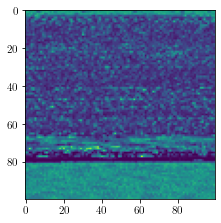

In [8]:
# Loading ORIGINAL dataset

original_data = %time pdfast.read_csv("original.csv")
print("Original dataset")

meta = original_data.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

# plotting one image as example
img_sample(original_data.iloc[-1])

In [9]:
# Trying SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where

pixels = [f"{x}_{y}" for x in range(100) for y in range(100)]

oversample = SMOTE()
X, y = original_data[pixels].values, original_data['CLASS'].values

X, y = oversample.fit_resample(X, y)
    
# Comment line below to use the original dataset without SMOTE
original_data = pd.DataFrame()
original_data[pixels] = X
original_data['CLASS'] = y

display(original_data)

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,0.266667,0.317647,0.305882,0.317647,0.294118,0.290196,0.301961,0.298039,0.298039,0.290196,...,0.364706,0.349020,0.360784,0.372549,0.349020,0.352941,0.368627,0.364706,0.388235,BENIGN
1,0.262745,0.141176,0.090196,0.196078,0.325490,0.403922,0.298039,0.305882,0.231373,0.290196,...,0.176471,0.172549,0.156863,0.184314,0.168627,0.172549,0.156863,0.207843,0.113725,MALIGN
2,0.360784,0.188235,0.298039,0.380392,0.356863,0.376471,0.321569,0.325490,0.329412,0.298039,...,0.047059,0.219608,0.039216,0.101961,0.266667,0.419608,0.160784,0.149020,0.129412,BENIGN
3,0.137255,0.258824,0.054902,0.047059,0.121569,0.070588,0.137255,0.137255,0.172549,0.141176,...,0.117647,0.184314,0.164706,0.203922,0.200000,0.015686,0.011765,0.000000,0.015686,BENIGN
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.331596,0.379562,0.214708,0.178811,0.092912,0.276999,0.233032,0.261688,0.243818,0.345552,...,0.397738,0.445861,0.577676,0.479027,0.398716,0.517647,0.463348,0.552636,0.567790,MALIGN
256,0.287569,0.324215,0.236986,0.232866,0.180353,0.287768,0.192932,0.220742,0.260336,0.340638,...,0.460656,0.616442,0.533532,0.382026,0.509528,0.484801,0.486813,0.470966,0.439754,MALIGN
257,0.326382,0.232004,0.205185,0.290344,0.305008,0.328166,0.204406,0.158109,0.226801,0.238194,...,0.383085,0.385318,0.244625,0.215072,0.211151,0.215314,0.227469,0.373978,0.270736,MALIGN
258,0.349020,0.380392,0.203922,0.164706,0.086275,0.274510,0.231373,0.266667,0.231786,0.336842,...,0.415489,0.417141,0.585553,0.514752,0.413212,0.504844,0.457994,0.544052,0.606396,MALIGN


## Training MINOS with the original dataset

Fiting classifier 208 52


2022-01-09 19:36:13.991103: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-09 19:36:19.230646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10792 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 100, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        1

CLASS
BENIGN    19
MALIGN    33
dtype: int64

2022-01-09 19:36:21.388932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-09 19:36:22.709757: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Accuracy: 1.0


CLASS
BENIGN    19
MALIGN    33
dtype: int64

Plotting plots/ROC.ORIGINAL.pdf


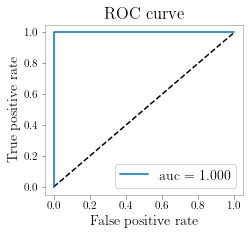

In [10]:
# We use the same plot proposed in minos, 80-20
train, test = split(original_data, 0.8)


print("Fiting classifier", len(train), len(test))
minos = MINOS()
minos.fit(train, test, model_name="original23.h5")
test_labels = test["CLASS"]
predictions = minos.predict(test)
print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

predictions = minos.predict(test).values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)

# Potting original roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_ORIGINAL.pdf")


## Getting augmented data and passing it to the original model


CPU times: user 3.19 s, sys: 3.15 s, total: 6.34 s
Wall time: 1min 1s
CPU times: user 3.08 s, sys: 3.15 s, total: 6.23 s
Wall time: 59.7 s
augmented_malign_bfs/malign_pencurimovie.xyz_2de044ff7777cbf3.ok.wasm.4239.wasm.png MALIGN
Augmented dataset


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs/bening_basic4gl.wasm.1274...,0.160784,0.164706,0.164706,0.168627,0.168627,0.168627,0.168627,0.168627,0.164706,...,0.337255,0.325490,0.317647,0.301961,0.298039,0.313725,0.325490,0.313725,0.341176,BENIGN
1,augmented_benign_bfs/bening_micr.io.wasm.516.w...,0.282353,0.168627,0.250980,0.247059,0.211765,0.262745,0.219608,0.172549,0.258824,...,0.329412,0.454902,0.474510,0.305882,0.356863,0.435294,0.549020,0.341176,0.494118,BENIGN
2,augmented_benign_bfs/bening_jakedeichert.githu...,0.156863,0.168627,0.172549,0.164706,0.160784,0.172549,0.168627,0.176471,0.176471,...,0.227451,0.219608,0.235294,0.258824,0.227451,0.227451,0.341176,0.219608,0.168627,BENIGN
3,augmented_benign_bfs/bening_creaturepack-wasm....,0.168627,0.172549,0.172549,0.172549,0.172549,0.164706,0.160784,0.164706,0.164706,...,0.301961,0.286275,0.301961,0.301961,0.305882,0.286275,0.309804,0.317647,0.294118,BENIGN
4,augmented_benign_bfs/bening_ammo.wasm.wasm.145...,0.156863,0.164706,0.160784,0.160784,0.160784,0.164706,0.160784,0.160784,0.160784,...,0.317647,0.309804,0.294118,0.286275,0.278431,0.290196,0.321569,0.301961,0.321569,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,augmented_malign_bfs/malign_bluegrassrivals.co...,0.164706,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.513725,0.486275,0.407843,0.427451,0.478431,0.466667,0.450980,0.486275,0.482353,MALIGN
39996,augmented_malign_bfs/malign_justproxy.co.uk.wa...,0.168627,0.156863,0.176471,0.164706,0.180392,0.180392,0.172549,0.180392,0.180392,...,0.317647,0.400000,0.490196,0.490196,0.447059,0.380392,0.415686,0.454902,0.349020,MALIGN
39997,augmented_malign_bfs/malign_browsermine.com_c7...,0.160784,0.164706,0.168627,0.172549,0.168627,0.168627,0.168627,0.168627,0.168627,...,0.486275,0.470588,0.478431,0.498039,0.490196,0.482353,0.450980,0.494118,0.494118,MALIGN
39998,augmented_malign_bfs/malign_hevcbay.com_440f91...,0.184314,0.145098,0.180392,0.180392,0.176471,0.164706,0.184314,0.176471,0.192157,...,0.192157,0.192157,0.227451,0.184314,0.235294,0.282353,0.207843,0.223529,0.203922,MALIGN


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
MALIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000
MALIGN,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000


(apply_list_of_funcs pid=1909116) 
(apply_list_of_funcs pid=1909116) 
Accuracy: 0.508
Plotting plots/ROC.AUGNMENTED.BREAKING1.SIZE40000.pdf


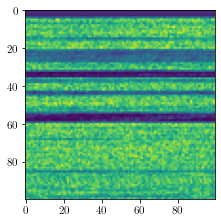

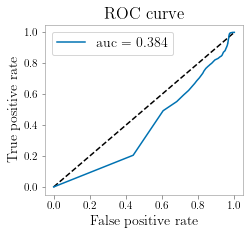

In [11]:
# The augmented dataset is massive, to be able to make the proof of concept we generated
# the datasets by using `shuf -n <SIZE> ...` to the original 36Gb dataset to get a random 
# permutation of the complete dataset

# Comment out the datasets to load less or more data

# augmented_benign = %time pdfast.read_csv("augmented1_benign.1k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.1k.csv")

# augmented_benign = %time pdfast.read_csv("augmented1_benign.2k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.2k.csv")


# augmented_benign = %time pdfast.read_csv("augmented1_benign.5k.csv")
# augmented_malign = %time pdfast.read_csv("augmented1_malign.5k.csv")

augmented_benign = %time pdfast.read_csv("augmented1_benign.20k.csv")
augmented_malign = %time pdfast.read_csv("augmented1_malign.20k.csv")


augmented1 = pdfast.concat([augmented_benign, augmented_malign], axis=0, ignore_index=True)


print("Augmented dataset")
display(augmented1)
meta = augmented1.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented1["CLASS"]
predictions = minos.predict(augmented1)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING1_SIZE{len(augmented1)}.pdf")

augmented_benign_bfs/bening_creaturepack-wasm.wasm.7408.wasm.png BENIGN
Original
7    original/creaturepack-wasm.wasm.png
Name: Name, dtype: object 7    BENIGN
Name: CLASS, dtype: object


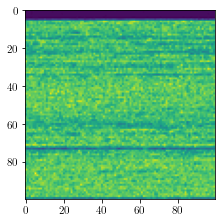

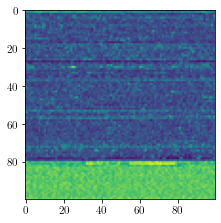

In [42]:
# after a lot of iterations
img_sample(augmented1.iloc[3])
plt.figure()

# original
original_data_again = pdfast.read_csv("original.csv")
pack = original_data_again[original_data_again['Name'] == 'original/creaturepack-wasm.wasm.png']

print("Original")
img_sample(pack)

## Step 2, training on augmented

Fiting classifier 32000 8000
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)       

,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009
MALIGN,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991


Accuracy: 0.999875


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009,4009
MALIGN,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991,3991


Plotting plots/ROC.AUGMENTED.pdf


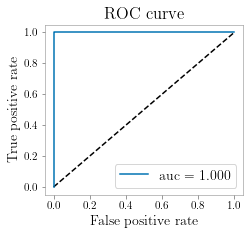

In [12]:
train, test = split(augmented1, 0.8)


print("Fiting classifier", len(train), len(test))
minos2 = MINOS()
minos2.fit(train, test, epochs=50, model_name="with_augmentation14.h5")
test_labels = test["CLASS"]
predictions = minos2.predict(test)
print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

predictions = minos2.predict(test).values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)

# Potting original roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGMENTED.pdf")


CPU times: user 749 ms, sys: 180 ms, total: 929 ms
Wall time: 11.5 s
CPU times: user 574 ms, sys: 243 ms, total: 817 ms
Wall time: 3.84 s


,Name,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,99_91,99_92,99_93,99_94,99_95,99_96,99_97,99_98,99_99,CLASS
0,augmented_benign_bfs/bening_www.figma.com.wasm...,0.149020,0.172549,0.176471,0.164706,0.160784,0.172549,0.176471,0.176471,0.168627,...,0.239216,0.203922,0.203922,0.133333,0.180392,0.152941,0.149020,0.164706,0.192157,BENIGN
1,augmented_benign_bfs/bening_basic4gl.wasm.937....,0.176471,0.196078,0.188235,0.200000,0.188235,0.200000,0.180392,0.188235,0.196078,...,0.380392,0.329412,0.329412,0.376471,0.431373,0.419608,0.431373,0.419608,0.435294,BENIGN
2,augmented_benign_bfs/bening_developers.arcgis....,0.152941,0.156863,0.172549,0.172549,0.180392,0.180392,0.176471,0.180392,0.168627,...,0.384314,0.262745,0.352941,0.290196,0.305882,0.290196,0.278431,0.290196,0.235294,BENIGN
3,augmented_benign_bfs/bening_canvas.apps.chrome...,0.145098,0.149020,0.152941,0.149020,0.149020,0.145098,0.149020,0.149020,0.149020,...,0.301961,0.305882,0.301961,0.278431,0.266667,0.266667,0.262745,0.262745,0.274510,BENIGN
4,augmented_benign_bfs/bening_boyan.io5.wasm.980...,0.160784,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,0.164706,...,0.203922,0.200000,0.207843,0.192157,0.188235,0.192157,0.200000,0.200000,0.196078,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,augmented_malign_bfs/malign_pharmatips.in.wasm...,0.160784,0.164706,0.164706,0.168627,0.168627,0.164706,0.164706,0.164706,0.164706,...,0.466667,0.384314,0.407843,0.341176,0.407843,0.407843,0.458824,0.450980,0.400000,MALIGN
1996,augmented_malign_bfs/malign_creative-solutions...,0.172549,0.168627,0.168627,0.168627,0.168627,0.172549,0.172549,0.172549,0.168627,...,0.517647,0.494118,0.462745,0.509804,0.458824,0.513725,0.470588,0.490196,0.454902,MALIGN
1997,augmented_malign_bfs/malign_tainiesonline.top....,0.160784,0.164706,0.168627,0.168627,0.168627,0.168627,0.164706,0.164706,0.164706,...,0.396078,0.400000,0.403922,0.396078,0.431373,0.427451,0.458824,0.411765,0.458824,MALIGN
1998,augmented_malign_bfs/malign_desirefx.me_12ee11...,0.156863,0.164706,0.172549,0.168627,0.172549,0.172549,0.172549,0.172549,0.176471,...,0.364706,0.356863,0.384314,0.396078,0.396078,0.349020,0.360784,0.305882,0.282353,MALIGN


Augmented dataset
(apply_list_of_funcs pid=1908902) 


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
MALIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__,__reduced__
CLASS,,,,,,,,,,,,,,,,
BENIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
MALIGN,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


(apply_func pid=1909112) 
(apply_list_of_funcs pid=1909384) 
Accuracy: 1.0
Plotting plots/ROC.AUGNMENTED.BREAKING1.VALIDATION.SIZE2000.pdf


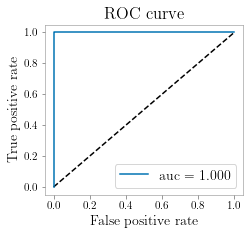

In [13]:
# Validating that the model learned this distribution


augmented_benign1 = %time pdfast.read_csv("augmented1_benign.1k.csv")
augmented_malign1 = %time pdfast.read_csv("augmented1_malign.1k.csv")


augmented11 = pdfast.concat([augmented_benign1, augmented_malign1], axis=0, ignore_index=True)

display(augmented11)

print("Augmented dataset")
meta = augmented11.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented11["CLASS"]
predictions = minos2.predict(augmented11)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING1_VALIDATION_SIZE{len(augmented11)}.pdf")

## Step 3

Try with another distribution on the augmented model

If the model learns the obfuscation on AUGMENTED1, what happens when the obfuscation follows another distribution ?

In [14]:
augmented_benign3 = %time pdfast.read_csv("augmented2_benign.csv")
augmented_malign3 = %time pdfast.read_csv("augmented2_malign.csv")


# Set the classes to the same representation
# comment out to use the original one
augmented_benign3 = augmented_benign3.iloc[:10000]
augmented_malign3 = augmented_malign3.iloc[:10000]
augmented3 = pdfast.concat([augmented_benign3, augmented_malign3], axis=0, ignore_index=True)

display(augmented3)

print("Augmented dataset 2")
meta = augmented3.groupby(by='CLASS').apply(lambda x: len(x))
display(meta)

test_labels = augmented3["CLASS"]
predictions = minos2.predict(augmented3)

print(f"Accuracy: {accuracy(predictions, test_labels)}")
predictions = predictions.values

test_labels = test_labels.apply(lambda x: MINOS.classes.index(x))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, predictions[:, 1])
auc_keras_val = auc_keras(fpr_keras, tpr_keras)


# Potting roc 
plot_roc(fpr_keras, tpr_keras, auc_keras_val, f"ROC_AUGNMENTED_BREAKING2_SIZE{len(augmented3)}.pdf")

KeyboardInterrupt: 

KeyboardInterrupt: 

AttributeError: 'NoneType' object has no attribute 'iloc'

The question is now, which transformations make the classifier to be innacurate, where is that 20% of failure ?

Future work: make wasm-mutate feature based to detect which kind of transformations.